In [165]:
import gzip
import itertools
import json
import pandas as pd

def transform_row(json_line):
    body = json_line.get("body", {})
    attributes = json_line.get("attributes", {}).get("sanity", {})
    # Creating a flat dictionary for each line
    flat_data = {
        "timestamp": json_line.get("timestamp"),
        "traceId": json_line.get("traceId"),
        "spanId": json_line.get("spanId"),
        "severityText": json_line.get("severityText"),
        "severityNumber": json_line.get("severityNumber"),
        "duration": body.get("duration", 0),
        "method": body.get("method"),
        "status": body.get("status"),
        "url": body.get("url"),
        "projectId": attributes.get("projectId"),
        "dataset": attributes.get("dataset"),
        "domain": attributes.get("domain"),
        "endpoint": attributes.get("endpoint"),
        "apiVersion": attributes.get("apiVersion"),
        "groqQueryIdentifier": attributes.get("groqQueryIdentifier"),
        "tags": list(attributes.get("tags", [])),
        "responseSize": body.get("responseSize", 0)
    }
    return flat_data

def load_and_transform_gzipped_ndjson(file_path, chunk_size=10000):
    def generate_transformed_rows(file_path):
        with gzip.open(file_path, 'rt', encoding='utf-8') as f:
            for line in f:
                json_line = json.loads(line)
                yield transform_row(json_line)
    
    chunks = []
    rows = generate_transformed_rows(file_path)
    while True:
        chunk = list(itertools.islice(rows, chunk_size))
        if not chunk:
            break
        chunks.append(pd.DataFrame(chunk))
    
    df = pd.concat(chunks, ignore_index=True)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['responseSize'] = pd.to_numeric(df['responseSize'], errors='coerce').fillna(0)
    return df

def filter_studio_tags(tags):
    return not any(tag.startswith('sanity.studio') for tag in tags)

df = load_and_transform_gzipped_ndjson('request-logs.ndjson.gz')
 

In [166]:
def generate_high_level_stats(df):
    min_date = df['timestamp'].min()
    max_date = df['timestamp'].max()
    stats = {
        "Total Requests": len(df),
        "Unique URLs": df['url'].nunique(),
        "Total Response Size - API (GB)": df[df['domain'] == 'api']['responseSize'].sum() / 1000 / 1000 / 1000,
        "Total Response Size - CDN (GB)": df[df['domain'] == 'cdn']['responseSize'].sum() / 1000 / 1000 / 1000,
        "Total Response Size - APICDN (GB)": df[df['domain'] == 'apicdn']['responseSize'].sum() / 1000 / 1000 / 1000,
        "Start Date": min_date.strftime('%Y-%m-%d %H:%M:%S'),
        "End Date": max_date.strftime('%Y-%m-%d %H:%M:%S'),
    }
    return pd.DataFrame([stats])

df_filtered = df[df['tags'].apply(filter_studio_tags)]
high_level_stats = generate_high_level_stats(df_filtered)
display(high_level_stats)


,Total Requests,Unique URLs,Total Response Size - API (GB),Total Response Size - CDN (GB),Total Response Size - APICDN (GB),Start Date,End Date
0,3819848,40884,1.517906,56.252049,13.450253,2024-03-04 00:03:28,2024-03-11 00:02:50


/var/folders/2q/433cm5217k10hnrcxt19hll40000gn/T/ipykernel_69462/1022497208.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


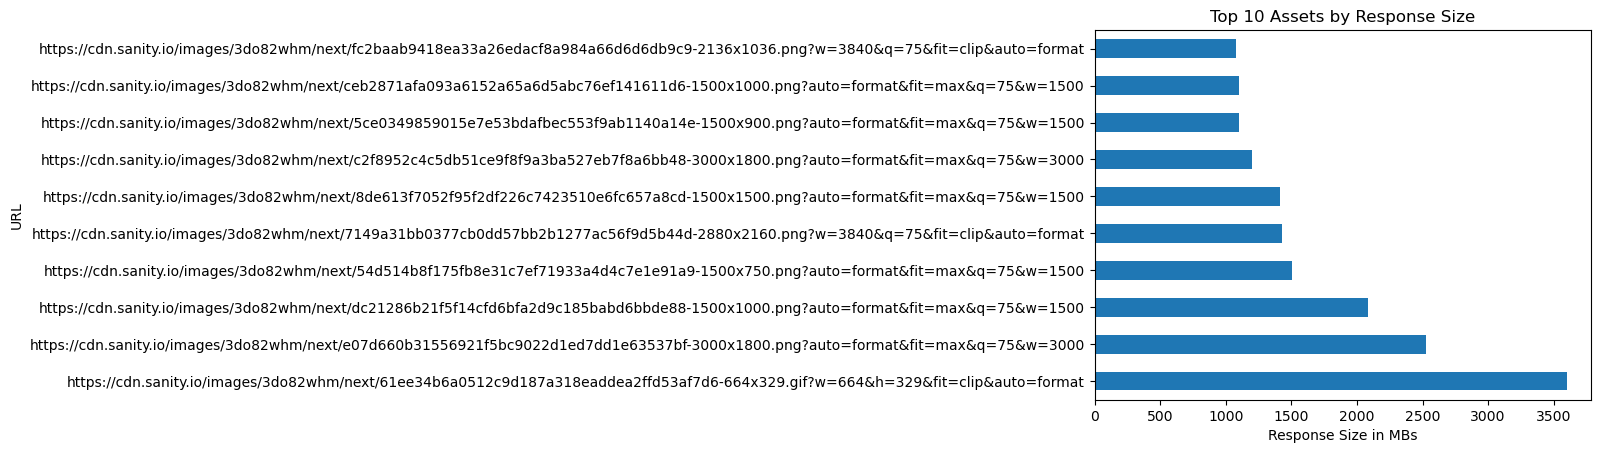

In [167]:
from matplotlib import pyplot as plt

def top_assets(df):
    df = df[(df['domain'] == 'cdn') & (df['tags'].apply(filter_studio_tags))]
    result = df.groupby('url').agg(
        responseMBs=('responseSize', lambda x: x.sum() / 1000 / 1000)
    ).reset_index().sort_values('responseMBs', ascending=False).head(10)
    
    return result

result = top_assets(df)

result.plot.barh(x='url', y='responseMBs', legend=False)
plt.xlabel('Response Size in MBs')
plt.ylabel('URL')
plt.title('Top 10 Assets by Response Size')
plt.tight_layout()
plt.show()

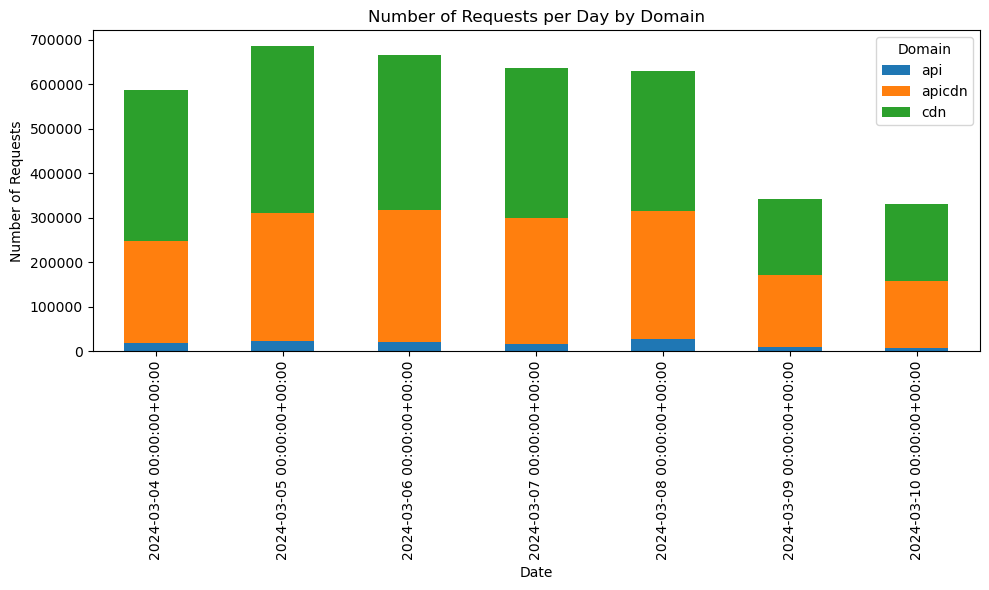

In [168]:
def plot_request_types_per_day_grouped_alt(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
        # Exclude records from today as they are incomplete.
        df = df[df['timestamp'].dt.date < pd.Timestamp('now').date()]
        daily_counts = df.set_index('timestamp').groupby(['domain']).resample('D').size().unstack(fill_value=0).unstack(fill_value=0)
        # Plotting with matplotlib for more control
        ax = daily_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Requests')
        ax.set_title('Number of Requests per Day by Domain')
        plt.legend(title='Domain')
        plt.tight_layout()
        plt.show()

plot_request_types_per_day_grouped_alt(df)


In [169]:
import urllib.parse


def top_longest_non_studio_api_requests(df):
    
    df_api = df[(df['domain'] == 'api') & (df['groqQueryIdentifier'] != 'null') & (df['groqQueryIdentifier'] != '') & (df['endpoint'] == 'query') & (df['tags'].apply(filter_studio_tags))].copy()
    
    df_api['timestamp'] = pd.to_datetime(df_api['timestamp'], utc=True)
    df_api.loc[:, 'duration (s)'] = pd.to_numeric(df_api['duration'], errors='coerce').fillna(0) / 1000
    
    # Filter out any rows where duration is 0 or negative
    df_api = df_api[df_api['duration (s)'] > 0]
    
    # Group by 'groqQueryIdentifier', get max 'duration', count, and first 'url'
    # Increase the display length of 'firstUrl' to avoid truncation
    pd.set_option('display.max_colwidth', None)
    result = df_api.groupby('groqQueryIdentifier').agg(
        maxDuration=('duration (s)', 'max'), 
        count=('duration (s)', 'count'),
        firstUrl=('url', 'first')
    ).reset_index().sort_values(['maxDuration', 'count'], ascending=False).head(10)
    
    return result

result = top_longest_non_studio_api_requests(df)
result['firstUrl'] = result['firstUrl'].apply(lambda x: urllib.parse.unquote_plus(x))
display(result.style.set_properties(**{'text-align': 'left'}))
